<hr style="border: 1.5px solid red;">

<h1 style="color: red;">1. Modelo LPC de Producción de Voz</h1>

<hr style="border: 1.5px solid red;">


El modelo LPC (Linear Prediction Coding) es un modelo digital utilizado para la producción de voz, comúnmente aplicado en codificación de voz para telefonía y videoconferencia. Este modelo permite al codificador extraer parámetros de la señal de voz, los cuales el decodificador utiliza para regenerarla.

## Funcionamiento Básico

La señal de voz `x(n)` se genera al excitar un **filtro todo-polos** `H(z)` (que representa el tracto vocal) con una señal `u(n)`, que puede ser de dos tipos:

1. **Excitación tipo ruido blanco**  
   - Representa sonidos sordos (/s/, /f/, etc.).  
   - Imita el flujo de aire de los pulmones.  
   - **Modelo resultante**: AR(p)

2. **Excitación tipo tren de impulsos**  
   - Representa sonidos sonoros (/a/, /m/, /b/, etc.).  
   - Imita la vibración de las cuerdas vocales.  
   - **Modelo resultante**: Todo-polos determinista

## Frecuencia de Pitch

En sonidos sonoros, la frecuencia de los impulsos corresponde a la **frecuencia de vibración de las cuerdas vocales**, conocida como **pitch**.  
Su inversa es el **período de pitch**.

## Modelado

- Ambos tipos de sonidos se modelan estimando el filtro `H(z)`.
- En sonidos sordos, solo hay correlaciones cortas.
- En sonidos sonoros, también hay correlaciones largas debidas a la excitación periódica.


In [66]:
%reset

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io.wavfile import write
from scipy.linalg import toeplitz  # comando de generacion matrices Toeplitz
from scipy.linalg import inv  # comando de inversion de matrices

# TODO from spectrum import * a ver que hacemos con esto
import macros

def autocorr_biased(x):
    """
    Calcula la autocorrelación sesgada de una señal x
    Devuelve un arreglo con 2N-1 muestras, centrado en el lag 0
    """
    N = len(x)

    # Autocorrelación de 'x' consigo misma (modo 'full' => incluye todos los lags posibles)
    r_x = np.correlate(x, x, mode="full") / N  # ! Sesgada: se divide por N fijo

    return r_x


def estimar_pitch_autocorrelacion(e, fs, fmin=50, fmax=500):
    """
    Estima el pitch de una señal usando autocorrelación.

    Parámetros:
    - e: señal de entrada (1D)
    - fs: frecuencia de muestreo
    - fmin, fmax: rango de búsqueda del pitch [Hz]

    Devuelve:
    - f0: pitch estimado en Hz
    - lag_pitch: lag correspondiente
    """
    # Calcular autocorrelación (sesgada o normalizada)
    autocorr = np.correlate(e, e, mode="full")
    autocorr = autocorr[len(autocorr) // 2 :]  # nos quedamos con la mitad positiva

    # Limitar búsqueda al rango de lags correspondiente a [fmax, fmin]
    min_lag = int(fs / fmax)
    max_lag = int(fs / fmin)

    # Buscar el máximo local en ese rango
    lag_pitch = np.argmax(autocorr[min_lag:max_lag]) + min_lag

    # Calcular frecuencia fundamental
    f0 = fs / lag_pitch

    return f0, lag_pitch



<hr style="border: 1.5px solid red;">

<h1 style="color: red;">2. Análisis espectral de un sonido sonoro</h1>

<hr style="border: 1.5px solid red;">

### Medir el pitch de la vocal directamente sobre la señal.

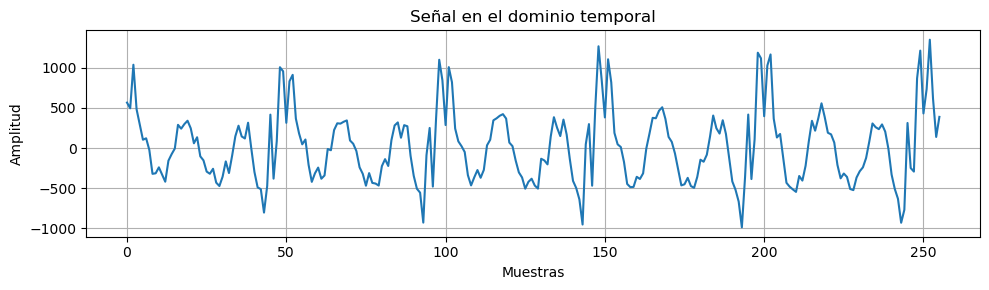

Pitch estimado: 160.00 Hz (Lag: 50 muestras)


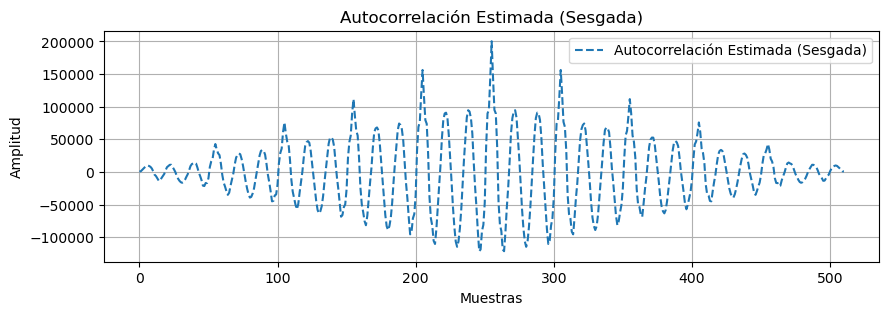

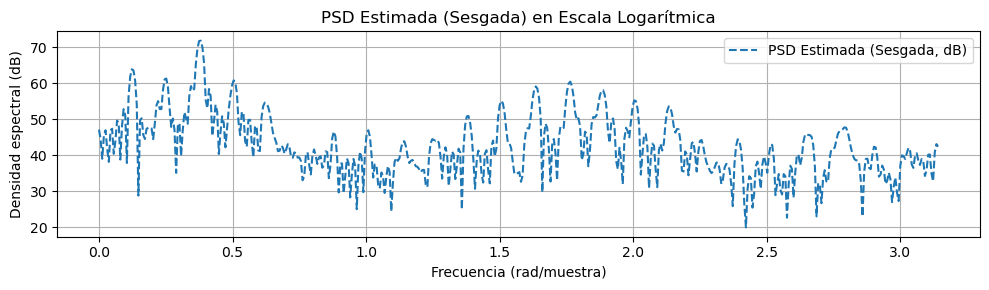

En el espectro se distinguen picos cada 0.5/4 radianes (en frecuencia normalizada).
Este número se halla dividiendo la frecuencia total de 2π radianes entre el lag del pitch.


In [67]:

#! Parámetros de configuración
fs = 8e3        # [Hz] Frecuencia de muestreo
L = 1024        # Tamaño de ventana (puede usarse para análisis en bloque)
N = 256         # Número de muestras de la vocal /e/

#! Verificar que el archivo exista en la ruta especificada
# * Cargar señal de la vocal /e/ desde archivo .asc
e = np.loadtxt("vocales/voc_e.asc")  

# ? Representación en el dominio temporal
plt.figure(figsize=(10, 3))
plt.plot(e)
plt.grid(True)
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal en el dominio temporal")
plt.tight_layout()
plt.show()

# ? Estimar pitch
f0, lag = estimar_pitch_autocorrelacion(e, fs)
print(f"Pitch estimado: {f0:.2f} Hz (Lag: {lag} muestras)")

# ! Representar la PSD estimada en dB y dominio de frecuencias normalizado (ω ∈ [0, π])
# Calculamos autocorrelación sesgada previamente con: autocorr_sesgada(e)
rx_sesgada = autocorr_biased(e)

# Estimamos la PSD aplicando la FFT a la autocorrelación
PSD_estimada_sesgada = np.abs(np.fft.fft(rx_sesgada, L))

# Nos quedamos con la mitad positiva del espectro (frecuencias en [0, π])
PSD_estimada_sesgada = PSD_estimada_sesgada[:int(L / 2)]

# Convertimos la PSD a escala logarítmica (dB)
PSD_estimada_sesgada_db = 10 * np.log10(PSD_estimada_sesgada + 1e-12)  # evitar log(0)

# ? Representamos la PSD en el dominio de frecuencias normalizado
# * Eje de frecuencias en [0, π] radianes/muestra
w = np.linspace(0, np.pi, len(PSD_estimada_sesgada))  # ! Asegúrate de que coincida con la PSD truncada

# * Gráfico de la autocorrelación
plt.figure(figsize=(10, 3))
plt.plot(rx_sesgada, label="Autocorrelación Estimada (Sesgada)", linestyle="--")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Autocorrelación Estimada (Sesgada)")
plt.grid(True)
plt.legend()

# * Gráfico de la PSD estimada en escala dB
plt.figure(figsize=(10, 3))
plt.plot(w, PSD_estimada_sesgada_db, label="PSD Estimada (Sesgada, dB)", linestyle="--")
plt.xlabel("Frecuencia (rad/muestra)")
plt.ylabel("Densidad espectral (dB)")
plt.title("PSD Estimada (Sesgada) en Escala Logarítmica")
plt.grid(True)
plt.legend()

# * Ajuste final y visualización
plt.tight_layout()
plt.show()

print("En el espectro se distinguen picos cada 0.5/4 radianes (en frecuencia normalizada).")
print("Este número se halla dividiendo la frecuencia total de 2π radianes entre el lag del pitch.")



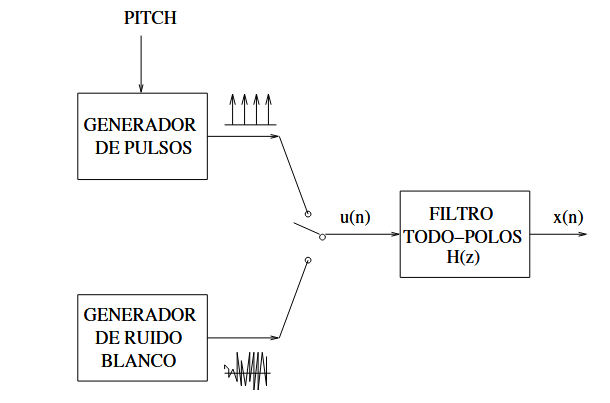



 Durante el análisis espectral de una vocal sostenida, se observa una serie de **picos finos regularmente espaciados** en el espectro. Estos picos representan los **armónicos** generados por la **excitación periódica** de las cuerdas vocales. Si el pitch es $f_0$, los armónicos aparecen en $f_0$, $2f_0$, $3f_0$, etc.

A su vez, estos picos están **modulados por una envolvente más suave**, que corresponde a la **respuesta del tracto vocal**, modelado como un filtro $H(\omega)$. Los picos anchos de esta envolvente se denominan **formantes**, y permiten distinguir entre vocales como /a/ y /e/ debido a sus diferentes frecuencias de resonancia.

En el dominio temporal, la **autocorrelación** de la señal muestra un **pico significativo** (distinto al lag 0) en el **retardo que corresponde al período fundamental** $T_0$. A partir de este lag, se puede calcular la frecuencia fundamental (pitch) con:

$$
f_0 = \frac{1}{T_0}
$$

Y en términos de muestras y frecuencia de muestreo $f_s$:

$$
f_0 = \frac{f_s}{\text{lag}_{\text{pitch}}}
$$

Este comportamiento es coherente con la teoría, ya que las vocales presentan **estructura periódica** que genera **correlaciones largas** en el tiempo y un **rizado espectral** en frecuencia.
___

## YULE WALKER EQUATIONS

Supose that we filter white noise $v(n)$ with a causal linear shif-invariant filter having a rational system function with p poles and q zeros. Since $x(n)$ and $v(n)$ are related by the linear constant coefficient difference equation:

$$
x(n) = \sum_{\ell=1}^{p} a_p(\ell) x(n - \ell) + \sum_{\ell=0}^{q} b_q(\ell) v(n - \ell)
$$

and the cross-correlation between $x(n)$ and $v(n)$ satisfies the same difference equation. If we multiply both sides by $x(n-k)$ and take $E[\cdot]$

$$
r_x(k) + \sum_{\ell=1}^{p} a_p(\ell) r_x(k - \ell) = \sum_{\ell=0}^{q} b_q(\ell) E[v(n - \ell) x(n - k)]
$$

Where:

$$
\begin{aligned}
E[v(n - \ell) x^*(n - k)] &= E \left[ v(n - \ell) \sum_{m=-\infty}^{\infty} v^*(m) h^*(n - k - m) \right] \\
&= \sum_{m=-\infty}^{\infty} E \left[ v(n - \ell) v^*(m)\right] h^*(n - k - m)  \\
&= \sum_{m=-\infty}^{\infty} \sigma_v^2 \delta(n-l-m) h^*(n - k - m)\\
&= \sigma_v^2 h^*(l - k)
\end{aligned}
$$

Assuming that $h(n)$ is causal, the sum on the right side, which we denote by $c_q(k)$, may be written as:
$$
c_q(k) = \sum_{\ell=0}^{q} b_q(\ell) h(k - \ell)
$$

Since $c_q(k) = 0$ for $k > q$, we can rewrite:
$$
\boxed{r_x(k) + \sum_{\ell=1}^{p} a_p(\ell) r_x(k - \ell) =
\begin{cases}
\sigma_v^2 \cdot c_q(k), & 0 \leq k \leq q \\
0, & k > q
\end{cases}}
$$
Which are the **Yule-Walker equations**.

$$
\begin{bmatrix}
r_x(0) & r_x(-1) & \cdots & r_x(-p) \\
r_x(1) & r_x(0) & \cdots & r_x(-p+1) \\
\vdots & \vdots & \ddots & \vdots \\
r_x(q) & r_x(q-1) & \cdots & r_x(q-p) \\
\cdots\cdots\cdots & \cdots\cdots \cdots&  \cdots\cdots\cdots &  \cdots\cdots\cdots \\
r_x(q+1) & r_x(q) & \cdots & r_x(q-p+1) \\
\vdots & \vdots & \ddots & \vdots \\
r_x(q+p) & r_x(q+p-1) & \cdots & r_x(q) 
\end{bmatrix}
\begin{bmatrix}
1 \\
a_p(1) \\
a_p(2) \\
\vdots \\
a_p(p)
\end{bmatrix}
= \sigma_v^2
\begin{bmatrix}
c_q(0) \\
c_q(1) \\
\vdots \\
c_q(q) \\
\cdots \cdots \\
0 \\
\vdots \\
0
\end{bmatrix}
$$

Therefore, the Yule-Walker equations may be used to extrapolate the autocorrelation sequence from a finite set of values of $r_x(k)$.  
For example, if $p \geq q$ and if $r_x(0), \dots, r_x(p-1)$ are known, then $r_x(k)$ for $k \geq p$ may be computed by:

$$
r_x(k) = - \sum_{\ell=1}^{p} a_p(\ell) r_x(k - \ell)
$$


---

## Autoregressive Processes AR(p)

A special type of $ARMA(p,q)$ process results when $q = 0$. In this case $x(n)$ is generated by filtering white noise with an all-pole filter of the form:

$$
H(z) = \frac{b(0)}{1 + \sum_{\ell=1}^{p} a_p(\ell) z^{-\ell}}
$$

An $ARMA(p,0)$ process is called an autoregressive process of order $p$ and will be referred to as an $AR(p)$ process. If $P(z) =  \sigma_v^2$:

$$
P_x(z) = \sigma_v^2 \cdot \frac{|b(0)|^2}{A_p(z) A_p^*(z)}
$$
queda
$$
\boxed{r(k) + \sum_{l=1}^{p} a_p(l)\, r(k - l) = \sigma_v^2\, b(0)\, h(k), \quad \forall k \geq 0}
$$

Donde $c_q(0) = b(0)\, h(0)^* = |b(0)|^2$ y, en forma matricial:

$$
\begin{bmatrix}
r(0) & r(1) & \cdots & r(p) \\
r(1) & r(0) & \cdots & r(p-1) \\
\vdots & \vdots & \ddots & \vdots \\
r(p) & r(p-1) & \cdots & r(0)
\end{bmatrix}
\begin{bmatrix}
1 \\
a_p(1) \\
\vdots \\
a_p(p)
\end{bmatrix}
=
\sigma_v^2\, |b(0)|^2
\begin{bmatrix}
1 \\
0 \\
\vdots \\
0
\end{bmatrix}
$$

<hr style="border: 1.5px solid red;">

<h1 style="color: red;">3. Modelo y espectro LPC de un sonido sonoro</h1>

<hr style="border: 1.5px solid red;">



La idea es que, si tienes una señal $x(n)$ y quieres aproximarla por un modelo AR, entonces para cada muestra $x(n)$ (con $n > p$) la puedes predecir como una combinación lineal de $p$ valores pasados:

$$
\hat{x}(n) = -\sum_{k=1}^{p} a_p(k)\, x(n - k)
$$

El error de predicción sería:

$$
e(n) = x(n) - \hat{x}(n) = x(n) + \sum_{k=1}^{p} a_p(k)\, x(n - k)
$$
Como en el método de Prony, el método de autocorrelación también puede expresarse en términos de encontrar una solución de mínimos cuadrados a un conjunto de ecuaciones lineales sobredeterminadas. Específicamente, en el **método de autocorrelación** deseamos encontrar un conjunto de coeficientes $a_p(k)$ tal que el error $e(n)$ sea igual a cero para $n > 0$, es decir,

$$
e(n) = x(n) + \sum_{k=1}^{p} a_p(k)\, x(n - k) = 0, \quad n > 0 \tag{1}
$$

En forma matricial, la ecuación (4.122) puede escribirse como:

$$
\mathbf{X}_p\, \bar{a}_p = -\mathbf{x}_1 \tag{2}
$$

donde la matriz $\mathbf{X}_p$ es una matriz de tamaño $(N + p) \times p$ dada por:

$$
\mathbf{X}_p =
\begin{bmatrix}
x(0) & 0 & 0 & \cdots & 0 \\
x(1) & x(0) & 0 & \cdots & 0 \\
x(2) & x(1) & x(0) & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
x(p-1) & x(p-2) & x(p-3) & \cdots & x(0) \\
x(p) & x(p-1) & x(p-2) & \cdots & x(1) \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
x(N-2) & x(N-3) & x(N-4) & \cdots & x(N-p-1) \\
x(N-1) & x(N-2) & x(N-3) & \cdots & x(N-p) \\
x(N) & x(N-1) & x(N-2) & \cdots & x(N-p+1) \\
0 & x(N) & x(N-1) & \cdots & x(N-p+2) \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & x(N)
\end{bmatrix}
$$

y el vector $\mathbf{x}_1$ es un vector columna de longitud $N + p$ definido como:

$$
\mathbf{x}_1 =
\begin{bmatrix}
x(1) \\
x(2) \\
\vdots \\
x(N) \\
0 \\
\vdots \\
0
\end{bmatrix} 
$$

La solución de mínimos cuadrados al sistema se determina resolviendo las siguientes ecuaciones normales:

$$
(\mathbf{X}_p^H \mathbf{X}_p)\, \bar{a}_p = \mathbf{X}_p^H \mathbf{x}_1
$$
___
Al igual que con el método de autocorrelación, el **método de covarianza** también puede formularse como un problema de aproximación por mínimos cuadrados. En particular, si establecemos el error de la Ecuación (1) igual a cero para $n$ en el intervalo $[p, N]$, obtenemos un conjunto de $(N - p + 1)$ ecuaciones lineales de la forma:

$$
\begin{bmatrix}
x(p-1) & x(p-2) & \cdots & x(0) \\
x(p) & x(p-1) & \cdots & x(1) \\
\vdots & \vdots & \ddots & \vdots \\
x(N-2) & x(N-3) & \cdots & x(N-p-1) \\
x(N-1) & x(N-2) & \cdots & x(N-p)
\end{bmatrix}
\begin{bmatrix}
a_p(1) \\
a_p(2) \\
\vdots \\
a_p(p)
\end{bmatrix}
=
\begin{bmatrix}
x(p) \\
x(p+1) \\
\vdots \\
x(N-1) \\
x(N)
\end{bmatrix} \tag{3}
$$

Es importante notar que estas ecuaciones corresponden a un subconjunto de $N - p + 1$ ecuaciones de la Ecuación (2), y que **no requieren información sobre $x(n)$ fuera del rango $[0, N]$**. Dado que estas ecuaciones forman un sistema sobredeterminado, se puede usar el mismo enfoque descrito para el método de autocorrelación para encontrar la mejor aproximación en el sentido de mínimos cuadrados.


In [ ]:



def coeficientes_AR_COV(x, p):
    """
    Estima los coeficientes AR(p) mediante el método de covarianza.

    Parámetros:
    -----------
    x : array_like
        Señal de entrada, x(n) para n = 0, 1, ..., N-1.
    p : int
        Orden del modelo AR (número de polos).

    Devuelve:
    --------
    a : ndarray
        Coeficientes del modelo AR en la forma: a[0] = 1, a[1], ..., a[p],
        de manera que:
            x(n) + ∑[k=1..p] a[k] x(n-k) = e(n)
    E_p : float
        Error cuadrático mínimo (energía del residuo) obtenido en la aproximación
        por mínimos cuadrados, análogo a la ecuación (4.126) o (4.132) en el libro.
    """
    
    # ?------------------------------------------------------
    # ? 1. Definiciones básicas
    # ?------------------------------------------------------
    N = len(x)  # * Longitud total de la señal
    if p >= N:
        raise ValueError("El orden p debe ser menor que la longitud de la señal.")

    # ?------------------------------------------------------
    # ? 2. Construcción de la matriz de regresores y del vector objetivo
    # ?    Para n = p, p+1, ..., N-1, se predice x(n) en función de:
    # ?    [x(n-1), x(n-2), ..., x(n-p)].
    # ?------------------------------------------------------
    
    # * Construir la primera columna de X:
    #   Se toman los valores desde x(p-1) hasta x(N-2) (inclusive).
    columna = x[p - 1 : N-1]      #  x(p-1), x(p+1), ..., x(N-2)  La longitud es N - p
    fila = x[:p][::-1]          # x(p-1), x(p-2), ..., x(0)     La longitud es p
    
    # * Construir la matriz de regresores X (dimensión (N-p) x p)
    X = toeplitz(columna, fila)
    
    # * Definir el vector de salida (target) d:
    d = x[p : N]    # d = [x(p), x(p+1), ..., x(N-1)]
    
    # ?------------------------------------------------------
    # ? 3. Resolución de las ecuaciones normales de covarianza
    # ?    Se resuelve: (X^H X) a_vec = - X^H d, donde a_vec = [a(1), ..., a(p)]
    # ?------------------------------------------------------
    X_H = X.conj().T                # * Transpuesta conjugada de X (útil para datos complejos)
    R_x = X_H @ X                   # * Matriz de autocorrelación de los regresores
    r_x = X_H @ d                   # * Vector de correlación cruzada con la salida
    A_partial = -inv(R_x) @ r_x     # ! Solución para los coeficientes a(1) ... a(p)
    
    # ?------------------------------------------------------
    # ? 4. Cálculo del error cuadrático mínimo E_p
    # ?    E_p = ∑[n=p]^(N-1) |e(n)|^2, con e(n) = x(n) + ∑[k=1]^(p) a[k] x(n-k)
    # ?------------------------------------------------------
    E_p = np.dot(d, d) + np.dot(A_partial, r_x)
    
    # ?------------------------------------------------------
    # ? 5. Construcción del vector de coeficientes del modelo AR
    # ?    Se define el polinomio:
    # ?      A(z) = 1 + ∑[k=1..p] a(k) z^{-k}
    # ?    Por convención, se añade a[0] = 1.
    # ?------------------------------------------------------
    a = np.concatenate(([1.0], A_partial))
    
    return a, E_p



def coeficientes_AR_YW(x, p):
    """
    Estima los coeficientes del modelo AR(p) y la varianza del ruido blanco
    usando las ecuaciones de Yule-Walker para k>p.

    Parámetros:
    x : array_like
        Señal de entrada (serie temporal)
    p : int
        Orden del modelo AR

    Retorna:
    A : ndarray
        Coeficientes AR incluyendo A[0] = 1
    sigma2 : float
        Varianza estimada del ruido blanco
    """

    N = len(x)

    # Calcular la autocorrelación sesgada de la señal
    r_x_biased = autocorr_biased(x)

    # Construir matriz Toeplitz R con r(0) hasta r(p-1)
    R = toeplitz(r_x_biased[N - 1 : N - 1 + p])

    # Vector del lado derecho: r(1) hasta r(p), negado
    r = -r_x_biased[N : N + p]

    # Resolver el sistema R·a = -r para obtener coeficientes AR
    A = np.linalg.solve(R, r)
    A = np.concatenate(([1.0], A))  # * Importante: A[0] = 1 por convención

    # Calcular la varianza del ruido blanco (sigma^2)
    sigma2 = r_x_biased[N - 1] + np.dot(A[1:], r_x_biased[N : N + p])

    return A, sigma2


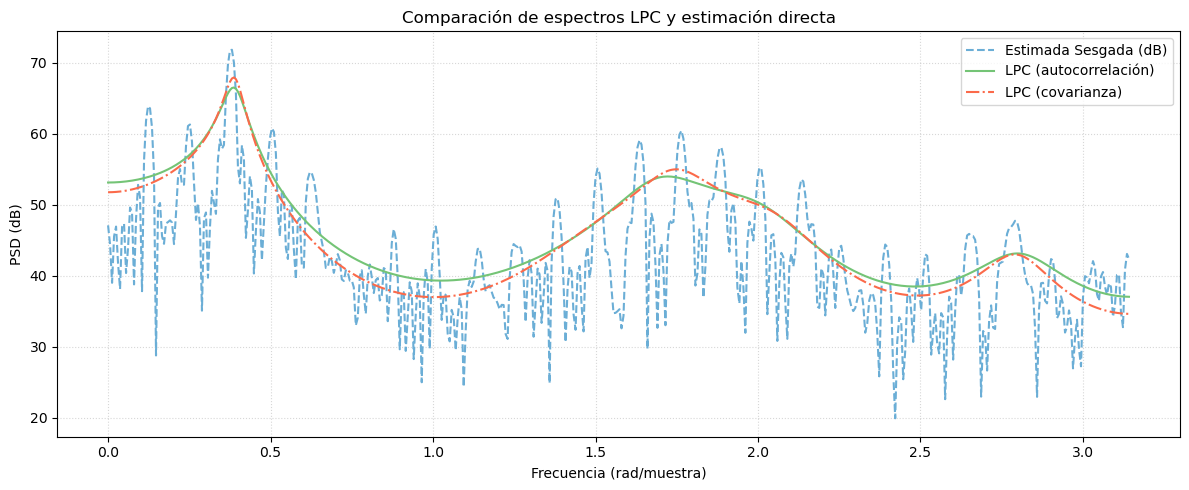

Coeficientes LPC (autocorrelación):
A_auto[0] = 1.000000
A_auto[1] = -0.617518
A_auto[2] = 0.130392
A_auto[3] = -0.660405
A_auto[4] = -0.017517
A_auto[5] = 0.480996
A_auto[6] = 0.249903
A_auto[7] = 0.044342
A_auto[8] = 0.044830
A_auto[9] = -0.320485
A_auto[10] = 0.163229
A_auto[11] = -0.124191
A_auto[12] = 0.071362

----------------------------------------

Coeficientes LPC (covarianza):
A_covar[0] = 1.000000
A_covar[1] = -0.602531
A_covar[2] = 0.172334
A_covar[3] = -0.790419
A_covar[4] = -0.011575
A_covar[5] = 0.465011
A_covar[6] = 0.370373
A_covar[7] = 0.096376
A_covar[8] = 0.058083
A_covar[9] = -0.439320
A_covar[10] = 0.169504
A_covar[11] = -0.179976
A_covar[12] = 0.160742


In [70]:
# ------------------------------------------------------
# * CONFIGURACIÓN INICIAL
# ------------------------------------------------------

p = 12        # Orden del modelo AR (número de polos)
L = 1024      # Tamaño de la FFT
fs = 8000     # Frecuencia de muestreo (Hz)
N = len(e)    # Número de muestras de la señal original

#? ------------------------------------------------------
#?  MODELO LPC - MÉTODO DE AUTOCORRELACIÓN
#?  ------------------------------------------------------

A_auto, sigma2_auto = coeficientes_AR_YW(e, p)

# * PSD LPC por autocorrelación
A_fft_auto = np.fft.fft(A_auto, L)
PSD_auto = sigma2_auto / (np.abs(A_fft_auto) ** 2 + 1e-12)
PSD_auto = PSD_auto[:L // 2]
PSD_auto_db = 10 * np.log10(PSD_auto)

# # TODO: GENERACIÓN DE SEÑAL SINTÉTICA CON MODELO LPC
# # Tren de impulsos como señal de excitación
# periodo = np.zeros(50)
# periodo[0] = 1.0
# excitation = np.tile(periodo, 100)

# # Filtrado por el modelo LPC
# e_sint = signal.lfilter([sigma2_auto], A_auto, excitation)

# # Normalización y exportación a WAV
# e_sint_norm = e_sint / np.max(np.abs(e_sint))
# write("e_sint.wav", rate=fs, data=(e_sint_norm * 32767).astype(np.int16))

#? ------------------------------------------------------
#? MODELO LPC - MÉTODO DE COVARIANZA
#? ------------------------------------------------------

A_covar, Emin = coeficientes_AR_COV(e, p)

# PSD LPC por covarianza
b0 = np.sqrt(Emin)
numerador = np.abs(b0) ** 2 / (N - p)
A_fft_covar = np.fft.fft(A_covar, L)
denominador = np.abs(A_fft_covar) ** 2 + 1e-12
PSD_covar = numerador / denominador
PSD_covar = PSD_covar[:L // 2]
PSD_covar_db = 10 * np.log10(PSD_covar)

#? ------------------------------------------------------
#? PSD ESTIMADA SESGADA COMO REFERENCIA
#? ------------------------------------------------------

rx_sesgada = autocorr_biased(e)
PSD_sesgada = np.abs(np.fft.fft(rx_sesgada, L))
PSD_sesgada = PSD_sesgada[:L // 2]
PSD_sesgada_db = 10 * np.log10(PSD_sesgada + 1e-12)


#? ------------------------------------------------------
#? GRAFICAR TODAS LAS PSDs
#? ------------------------------------------------------
w = np.linspace(0, np.pi, L // 2)  # Frecuencia normalizada


plt.figure(figsize=(12, 5))

plt.plot(w, PSD_sesgada_db, label="Estimada Sesgada (dB)", linestyle="--", color="#6baed6")  # Azul
plt.plot(w, PSD_auto_db, label="LPC (autocorrelación)", linestyle="-", color="#74c476")     # Verde
plt.plot(w, PSD_covar_db, label="LPC (covarianza)", linestyle="-.", color="#fb6a4a")        # Rojo

plt.xlabel("Frecuencia (rad/muestra)")
plt.ylabel("PSD (dB)")
plt.title("Comparación de espectros LPC y estimación directa")
plt.grid(True, linestyle=":", alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# * Imprimir coeficientes LPC estimados por autocorrelación
print("Coeficientes LPC (autocorrelación):")
for i, coef in enumerate(A_auto):
    print(f"A_auto[{i}] = {coef:.6f}")

print("\n" + "-"*40 + "\n")

# * Imprimir coeficientes LPC estimados por covarianza
print("Coeficientes LPC (covarianza):")
for i, coef in enumerate(A_covar):
    print(f"A_covar[{i}] = {coef:.6f}")


<hr style="border: 1.5px solid red;">

<h1 style="color: red;">4. Amálisis Homomórfico</h1>

<hr style="border: 1.5px solid red;">


In [ ]:
def coef_cepstrales(vocal, p):
    """
    Calcula los coeficientes cepstrales LPC de la vocal a partir del modelo AR obtenido 
    mediante el método de Yule-Walker.

    Parámetros:
      vocal : array_like
          Señal de la vocal.
      p : int
          Orden del modelo AR.

    Devuelve:
      coef : ndarray
          Vector de 12 coeficientes cepstrales (excluyendo c(0)) que describen la envolvente 
          espectral de la vocal.
    """
    L = 1024  # * Tamaño de la FFT
    # * Estimar coeficientes AR y la varianza mediante Yule-Walker
    A_estimados, sigma2_estimado = coeficientes_AR_YW(vocal, p)
    
    # * Calcular el espectro LPC: P_LPC(ω) = sigma2 / |A(e^(−jω))|^2
    A_fft = np.fft.fft(A_estimados, L)
    PSD_LPC = sigma2_estimado / (np.abs(A_fft) ** 2 + 1e-12)
    PSD_LPC = PSD_LPC[:L // 2]
    PSD_LPC_db = 10 * np.log10(PSD_LPC)
    
    # * Calcular el cepstrum LPC mediante la IFFT del logaritmo del espectro
    c_x_LPC = np.fft.ifft(PSD_LPC_db, L).real
    # * Se descarta c(0) debido a su gran rango dinámico y se toman los 12 primeros coeficientes
    coef = c_x_LPC[1:13]
    
    return coef

___

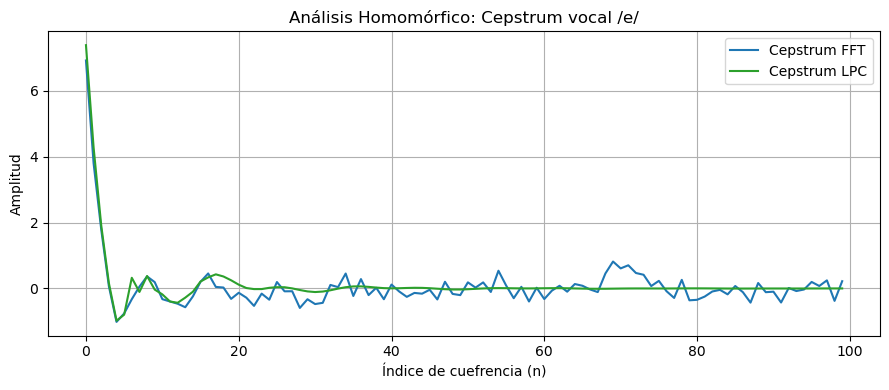

In [79]:

# * Ejemplo: calcular cepstrum FFT y cepstrum LPC de la vocal "e"
e = np.loadtxt("vocales/voc_o.asc")

# * PSD estimada por periodograma (ej. usando autocorrelación)
rx_sesgada = autocorr_biased(e)
PSD_estimada = np.abs(np.fft.fft(rx_sesgada, L))
PSD_estimada_db = 10*np.log10(PSD_estimada + 1e-12)

# * Cepstrum FFT
c_e_fft = np.fft.ifft(PSD_estimada_db, L).real
c_e_fft = c_e_fft[1:101]  # Excluye c(0)

# * Cepstrum LPC (usando la función anterior)
A_e, sigma2_e = coeficientes_AR_YW(e, p)
A_fft_e = np.fft.fft(A_e, L)
PSD_e = sigma2_e / (np.abs(A_fft_e)**2 + 1e-12)
PSD_e_db = 10 * np.log10(PSD_e + 1e-12)
c_e_lpc = np.fft.ifft(PSD_e_db, L).real
c_e_lpc = c_e_lpc[1:101]

# * Graficar
plt.figure(figsize=(9,4))
plt.plot(c_e_fft, label="Cepstrum FFT", color="tab:blue")
plt.plot(c_e_lpc, label="Cepstrum LPC", color="tab:green")
plt.xlabel("Índice de cuefrencia (n)")
plt.ylabel("Amplitud")
plt.title("Análisis Homomórfico: Cepstrum vocal /e/")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



<hr style="border: 1.5px solid red;">

<h1 style="color: red;">5. Reconocimiento de vocales</h1>

<hr style="border: 1.5px solid red;">


In [80]:
def identificar_vocal(vocal_desconocida, p):
    """
    Identifica la vocal desconocida comparando los coeficientes cepstrales LPC
    con los de las vocales de referencia. Se utiliza la distancia euclidiana para la comparación.

    Parámetros:
      vocal_desconocida : array_like
          Señal de la vocal desconocida.
      p : int
          Orden del modelo AR para el cálculo LPC.

    Devuelve:
      string: nombre de la vocal identificada ('a', 'e', 'i', 'o' o 'u').
    """
    # * Cargar las señales de las vocales conocidas de referencia
    a_ref = np.loadtxt("vocales/voc_a.asc")
    e_ref = np.loadtxt("vocales/voc_e.asc")
    i_ref = np.loadtxt("vocales/voc_i.asc")
    o_ref = np.loadtxt("vocales/voc_o.asc")
    u_ref = np.loadtxt("vocales/voc_u.asc")
    
    nombres = ["a", "e", "i", "o", "u"]
    vocales = [a_ref, e_ref, i_ref, o_ref, u_ref]
    
    # * Calcular los coeficientes cepstrales para la vocal desconocida
    coef_desconocida = coef_cepstrales(vocal_desconocida, p)
    
    # * Inicializamos una lista para almacenar las distancias
    distancias = []
    for vocal_conocida in vocales:
        # * Calcular coeficientes cepstrales para cada vocal de referencia
        coef_conocida = coef_cepstrales(vocal_conocida, p)
        # * Calcular la distancia euclidiana entre el vector desconocido y el de referencia
        distancia = np.linalg.norm(coef_desconocida - coef_conocida)
        distancias.append(distancia)
    
    # * La vocal identificada es aquella cuya distancia es mínima
    indice_minimo = np.argmin(distancias)
    
    return nombres[indice_minimo]


___

In [81]:

# * Cargar la vocal DESCONOCIDA
vocal_desconocida = np.loadtxt("vocales/voc_i.asc")  # Se asume que existe en la carpeta 'vocales'

# * Identificar la vocal desconocida
vocal_id = identificar_vocal(vocal_desconocida, p)
print("La vocal identificada es:", vocal_id)

#? =============================================================================
#? (Opcional) Generar y exportar señal sintética con modelo covarianza
#? =============================================================================
# """
# numerador = ...
# A_estimados_covar = ...
# periodo = np.zeros(50)
# periodo[0] = 1.0
# excitation = periodo.copy()
# for nrep in range(100):
#     excitation = np.concatenate((excitation, periodo))

# e_sint_covar = signal.lfilter(numerador, A_estimados_covar, excitation)
# write("e_sint_covar.wav", fs, e_sint_covar.astype(np.int16))
# """

La vocal identificada es: i
